In [1]:
import os
import glob
import pickle

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.signal import deconvolve, find_peaks, butter, filtfilt
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d

In [2]:
# define a high pass function
def high_pass_filter(ts, fs, cutoff=20):
    nyquist = fs / 2
    cutoff = cutoff / nyquist
    b, a = butter(2, cutoff, btype='high', analog=False)
    return filtfilt(b, a, ts)

def low_pass_filter(ts, fs, cutoff=1):
    nyquist = fs / 2
    cutoff = cutoff / nyquist
    b, a = butter(2, cutoff, btype='low', analog=False)
    return filtfilt(b, a, ts)

def band_pass_filter(ts, fs, low_cutoff=0.5, high_cutoff=50):
    nyquist = fs / 2
    low_cutoff = low_cutoff / nyquist
    high_cutoff = high_cutoff / nyquist
    b, a = butter(2, [low_cutoff, high_cutoff], btype='band', analog=False)
    return filtfilt(b, a, ts)

def thresholded_detection(ts, threshold=2.5, distance=5):
    normalized_ts = ts / np.std(ts)
    # detect the peaks in normalized_ts
    peak_post = find_peaks(normalized_ts, height=threshold, distance=distance)[0]
    return peak_post

def fuzzy_set_difference(A, B, delta=2):
    return [a for a in A if all(abs(a - b) > delta for b in B)]

# calculate the false positive and false negative rate
def calculate_fpr_fnr(true_pos, detected_pos, wid=3):
    false_pos = fuzzy_set_difference(detected_pos, true_pos, delta=wid)
    false_neg = fuzzy_set_difference(true_pos, detected_pos, delta=wid)
    return len(false_pos) / len(detected_pos), len(false_neg) / len(true_pos)  # proportion of wrong events in detection, proportion of missed events in real data

def improve_peak_pos(proposed_peaks, trace, wid=4):
    # find the actual peaks with highest values near the proposed peaks
    detected_peaks = []
    for peak in proposed_peaks:
        if peak < wid or peak > len(trace) - wid:
            detected_peaks.append(peak)
            continue
        detected_peaks.append(peak - wid + np.argmax(trace[peak-wid:peak+wid+1]))
    return np.array(detected_peaks)

def signal_snr(sig, pos):
    # assume real signal is positive and noise is symmetric
    s = np.mean(sig[pos])
    neg_sig = sig[sig<0]
    n = np.sqrt(np.mean(neg_sig**2))
    return s / n

In [3]:
class MiniDetection(object):
    def __init__(self, ftrace, tf, vtrace, tv, template_peak_offset=0, vthresh=3, fthresh=2.5):
        self.ftrace_raw = ftrace
        self.tf = tf
        self.vtrace_raw = vtrace
        self.tv = tv
        self.fs = np.round(1 / np.mean(np.diff(self.tf)))
        self.vthresh = vthresh
        self.fthresh = fthresh
        self.template_peak_offset = template_peak_offset
        self.template = None
        self.decon_template = None
        self.decon_ftrace = None
        self.decon_vtrace = None
        self.v_mini_pos = None
        self.f_mini_pos = None
        self.v_to_f_lag = None
        self.lag_corr = None

        self._downsample_vtrace()
    
    def _downsample_vtrace(self):
        self.vtrace_raw = interp1d(self.tv, self.vtrace_raw, axis=0, fill_value='extrapolate')(self.tf)

    def filter_traces(self, low_cutoff=0.5, high_cutoff=50):
        self.ftrace = band_pass_filter(self.ftrace_raw, self.fs, low_cutoff, high_cutoff)
        self.vtrace = band_pass_filter(self.vtrace_raw, self.fs, low_cutoff, high_cutoff)

    def deconvolve(self, trace, template, filter_sigma=0, hp_cutoff=None):
        if filter_sigma > 0:
            trace = gaussian_filter(trace, filter_sigma)
        decon_trace, _ = deconvolve(trace, template)
        if hp_cutoff is not None and hp_cutoff > 0:
            decon_trace = high_pass_filter(decon_trace, self.fs, cutoff=hp_cutoff)
        return decon_trace
    
    def detect_events(self, decon_trace, trace, threshold=2.5, distance=5):
        detected_spike_pos = thresholded_detection(decon_trace, threshold=threshold, distance=distance)
        improved_spike_pos = improve_peak_pos(detected_spike_pos+self.template_peak_offset, trace)
        detection_fedility = signal_snr(decon_trace, detected_spike_pos)
        mini_snr = signal_snr(trace, improved_spike_pos)
        return improved_spike_pos, detection_fedility, mini_snr
    
    def time_lagged_correlation(self, lag_range=150):
        lags = np.arange(-lag_range, lag_range+1)
        N = lag_range
        ftrace = self.ftrace
        vtrace = self.vtrace
        corr = np.zeros(len(lags))
        for j, lag in enumerate(lags):
            corr[j] = np.corrcoef(vtrace[N:len(ftrace)-N-lag], ftrace[N + lag:len(ftrace)-N])[0,1]
        self.v_to_f_lag = lags[np.argmax(corr)]
        self.lag_corr = (lags, corr)
    
    def compare_ephys_optical_detection(self, wid=3, distance=20):
        if self.decon_ftrace is None or self.decon_vtrace is None:
            raise ValueError('Deconvolve the traces first!')
        if self.v_to_f_lag is None:
            self.time_lagged_correlation()
        self.v_mini_pos,_, _ = self.detect_events(self.decon_vtrace, self.vtrace, threshold=self.vthresh, distance=distance)  
        self.f_mini_pos,_, _ = self.detect_events(self.decon_ftrace, self.ftrace, threshold=self.fthresh, distance=distance)  
        fpr, fnr = calculate_fpr_fnr(self.v_mini_pos+self.v_to_f_lag, self.f_mini_pos, wid=wid)
        return fpr, fnr    
    
    def save_QC_figure(self, zoom_range=[0, 10], save_path=None):
        '''
        The QC figure has 2*3 subplots:
        1, the time-lagged cross-correlation between the fluorescence and voltage traces
        2, zoomin view of the voltage trace with detected mini events
        3, zoomin view of the fluorescence trace with detected mini events
        4, empty
        5, zoomin view of the deconvolved voltage trace with detected mini events and the thresholded
        6, zoomin view of the deconvolved fluorescence trace with detected mini events and the thresholded
        note: zoom range is in seconds
        '''
        if self.lag_corr is None:
            self.time_lagged_correlation()
        if self.v_mini_pos is None or self.f_mini_pos is None:
            self.compare_ephys_optical_detection()
        fig, ax = plt.subplots(2, 3, figsize=(15, 10))
        lags, corr = self.lag_corr
        ax[0, 0].plot(lags, corr)
        ax[0, 0].axvline(self.v_to_f_lag, color='r', linestyle='--')
        ax[0, 0].text(self.v_to_f_lag, 0.5, f'{self.v_to_f_lag} frames', color='r')
        ax[0, 0].set_ylim([-0.2, 1.0])
        ax[0, 0].set_title('Time-lagged cross-correlation')
        ax[0, 0].set_xlabel('Lag (frames)')
        ax[0, 0].set_ylabel('Correlation')

        ax[0, 1].plot(self.tf, self.vtrace)
        ax[0, 1].set_xlim(zoom_range)
        ax[0, 1].set_ylim([-2, 5])
        ax[0, 1].set_title('Voltage trace with detected mini events')
        ax[0, 1].scatter(self.tf[self.v_mini_pos], self.vtrace[self.v_mini_pos], color='r', s=10)

        ax[0, 2].plot(self.tf, self.ftrace)
        ax[0, 2].set_xlim(zoom_range)
        ax[0, 2].set_ylim([-2, 4])
        ax[0, 2].set_title('Fluorescence trace with detected mini events')
        ax[0, 2].scatter(self.tf[self.f_mini_pos], self.ftrace[self.f_mini_pos], color='r', s=10)

        ax[1, 0].axis('off')
        ax[1, 1].plot(self.tf[0:len(self.decon_vtrace)], self.decon_vtrace)
        ax[1, 1].axhline(self.vthresh*np.std(self.decon_vtrace), color='r', linestyle='--')
        ax[1, 1].set_xlim(zoom_range)
        ax[1, 1].set_ylim([-0.2, 1.5])
        ax[1, 1].set_title('Deconvolved voltage trace with detected mini events')

        ax[1, 2].plot(self.tf[0:len(self.decon_ftrace)], self.decon_ftrace)
        ax[1, 2].axhline(self.fthresh*np.std(self.decon_ftrace), color='r', linestyle='--')
        ax[1, 2].set_xlim(zoom_range)
        ax[1, 2].set_ylim([-0.2, 0.8])
        ax[1, 2].set_title('Deconvolved fluorescence trace with detected mini events')

        plt.tight_layout()
        if save_path is not None:
            plt.savefig(save_path)
            plt.close()
        else:
            plt.show()


In [4]:
def adding_noise(trace, fs, adjust_factor):
    noise = high_pass_filter(trace, fs, cutoff=20)
    noise_level = np.sqrt(adjust_factor**2-1)
    new_noise = np.random.normal(0, noise_level*np.std(noise), len(noise))
    return trace + new_noise

## Run on the mini dataset

In [5]:
low_cutoff = 0.5
high_cutoff = 50
template_peak_offset = 0

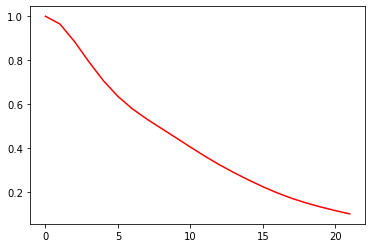

In [6]:
# load the deconvolution template
global_template_path = 'mini_deconvolution_template.npy'

if os.path.exists(global_template_path):
    global_template = np.load(global_template_path)
plt.plot(global_template, 'r')

In [7]:
pkl_files = glob.glob(os.path.join('./dual_recording_dataset/mini_detection_results/', 'ASAP5*.pkl'))
save_dir = './dual_recording_dataset/mini_detection_results/ASAP5_addnoise/'
save_dir = './dual_recording_dataset/mini_detection_results/ASAP5_highnoise/'  # adjust factor 2
# pkl_files = glob.glob(os.path.join('./dual_recording_dataset/mini_detection_results/', 'Voltron2*.pkl'))
# save_dir = './dual_recording_dataset/mini_detection_results/Voltron2'
pkl_files.sort()

In [14]:
FP_list = []
FN_list = []
ephys_mini_snr_list = []
event_number_list = []
for i in range(len(pkl_files)):
    pkl_file = pkl_files[i]
    with open(pkl_file, 'rb') as f:
        data = pickle.load(f)  #{'vtrace': test_trace_v, 'tv': tv, 'ftrace': test_trace_f, 'tf': tf, 'template_peaks':selected_peaks, 'template': template, 'decon_template': decontemplate}
    test_trace_v = data['vtrace']
    tv = data['tv']
    test_trace_f = data['ftrace']
    tf = data['tf']
    decon_template = data['decon_template']

    adjust_factor = 1.5
    test_trace_f = adding_noise(test_trace_f, 1/np.mean(np.diff(tf)), adjust_factor)

    detection_QC_path = os.path.join(save_dir, os.path.basename(pkl_file).replace('.pkl', '_detection.png'))
    #md = MiniDetection(test_trace_f, tf, test_trace_v, tv, template_peak_offset=template_peak_offset, vthresh=2.5, fthresh=2)
    md = MiniDetection(test_trace_f, tf, test_trace_v, tv, template_peak_offset=template_peak_offset, vthresh=2.5, fthresh=2.5)
    md.filter_traces(low_cutoff, high_cutoff)
    md.decon_template = global_template
    md.decon_vtrace = md.deconvolve(md.vtrace, md.decon_template, filter_sigma=3, hp_cutoff=2)
    md.decon_ftrace = md.deconvolve(md.ftrace, md.decon_template, filter_sigma=3, hp_cutoff=2) # applying gaussian filter is commutative with the deconvolution

    fpr, fnr = md.compare_ephys_optical_detection(wid=4)
    print('False positive rate:', fpr)
    print('False negative rate:', fnr)
    #md.save_QC_figure(zoom_range=[10, 15], save_path=detection_QC_path)
    FP_list.append(fpr)
    FN_list.append(fnr)
    event_number_list.append(len(md.f_mini_pos))

    # save the results into pickle file
    # results include: v_mini_pos, f_mini_pos, v_to_f_lag, lag_corr, vtrace and ftrace
    results = {'v_mini_pos': md.v_mini_pos, 'f_mini_pos': md.f_mini_pos, 'v_to_f_lag': md.v_to_f_lag, 'lag_corr': md.lag_corr, 
               'vtrace': md.vtrace, 'ftrace': md.ftrace, 'raw_vtrace': md.vtrace_raw, 'raw_ftrace': md.ftrace_raw, 'tf':tf}
    with open(os.path.join(save_dir, os.path.basename(pkl_file).replace('.pkl', '_detection_results.pkl')), 'wb') as f:
        pickle.dump(results, f)

False positive rate: 0.5
False negative rate: 0.6739130434782609
False positive rate: 0.7096774193548387
False negative rate: 0.8615384615384616
False positive rate: 0.21505376344086022
False negative rate: 0.46715328467153283
False positive rate: 0.7083333333333334
False negative rate: 0.8390804597701149
False positive rate: 0.6964285714285714
False negative rate: 0.6458333333333334
False positive rate: 0.4909090909090909
False negative rate: 0.7431192660550459


In [15]:
np.mean(FP_list), np.mean(FN_list)

(0.5534003630777825, 0.7051063081411248)

In [61]:
import csv
with open(os.path.join(save_dir, 'FNR_FPR.csv'), mode='w') as f:
    writer = csv.writer(f)
    writer.writerow(['FNR', 'FPR'])
    for i in range(len(FP_list)):
        writer.writerow([FN_list[i], FP_list[i]])

In [57]:
event_number_list

[79, 41, 111, 31, 45, 59]

In [12]:
np.mean(FP_list), np.mean(FN_list)

(0.4817820859174242, 0.5612422395832534)

In [13]:
event_number_list

[57, 66, 38, 52, 56, 36, 35]

In [ ]:
# write FP_list and FN_list into a csv file
import csv
with open(os.path.join(save_dir, 'mini_detection_results.csv'), mode='w') as f:
    writer = csv.writer(f)
    writer.writerow(['FP', 'FN', 'event_number'])
    for i in range(len(FP_list)):
        writer.writerow([FP_list[i], FN_list[i], event_number_list[i]])

## Draw example traces of detection

In [ ]:
def show_neuron_trace(t, trace, peak_position, window=[0,10], ylim=[0,1], line_color='k', line_width=0.5, thr_or_marker=False, peak_color='r', peak_height=2.8, marker_size=2, save_path=None):
    fig = plt.figure(figsize=(3.2, 0.8))
    plt.rcParams['font.size'] = '7'
    plt.rcParams['font.sans-serif'] = "Arial"
    plt.rcParams['font.family'] = "sans-serif"
    ax = fig.add_subplot(111)  
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.tick_params(axis='y', which='major', direction='out',length=2, width=line_width)

    ax.plot(t, trace, color=line_color, linewidth=line_width)
    if not thr_or_marker:
        ax.scatter(t[peak_position], peak_height*np.ones_like(peak_position), s=marker_size, color=peak_color, facecolors='none', linewidth=line_width)
    else:
        thr = np.std(trace) * peak_height
        ax.axhline(thr, color=peak_color, linestyle='--', linewidth=line_width)
    ax.set_xlim(window)
    if ylim:
        ax.set_ylim(ylim)
    
    plt.tight_layout(pad=0, h_pad=None, w_pad=None)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        plt.close(fig)
    else:
        plt.show()

### ASAP5

In [18]:
pkl_files = glob.glob(os.path.join('./dual_recording_dataset/mini_detection_results/', 'ASAP5*.pkl'))
pkl_files.sort()
save_dir = './dual_recording_dataset/mini_detection_results/ASAP5'

In [24]:
index = 5
pkl_file = pkl_files[index]
with open(pkl_file, 'rb') as f:
    data = pickle.load(f)  #{'vtrace': test_trace_v, 'tv': tv, 'ftrace': test_trace_f, 'tf': tf, 'template_peaks':selected_peaks, 'template': template, 'decon_template': decontemplate}
test_trace_v = data['vtrace']
tv = data['tv']
test_trace_f = data['ftrace']
tf = data['tf']

md = MiniDetection(test_trace_f, tf, test_trace_v, tv, template_peak_offset=template_peak_offset, vthresh=2.5, fthresh=2.5)
md.filter_traces(low_cutoff, high_cutoff)
md.decon_template = global_template
md.decon_vtrace = md.deconvolve(md.vtrace, md.decon_template, filter_sigma=3, hp_cutoff=2)
md.decon_ftrace = md.deconvolve(md.ftrace, md.decon_template, filter_sigma=3, hp_cutoff=2)  # applying gaussian filter is commutative with the deconvolution
fpr, fnr = md.compare_ephys_optical_detection(wid=4, distance=20)
print('False positive rate:', fpr)
print('False negative rate:', fnr)

False positive rate: 0.23809523809523808
False negative rate: 0.5596330275229358


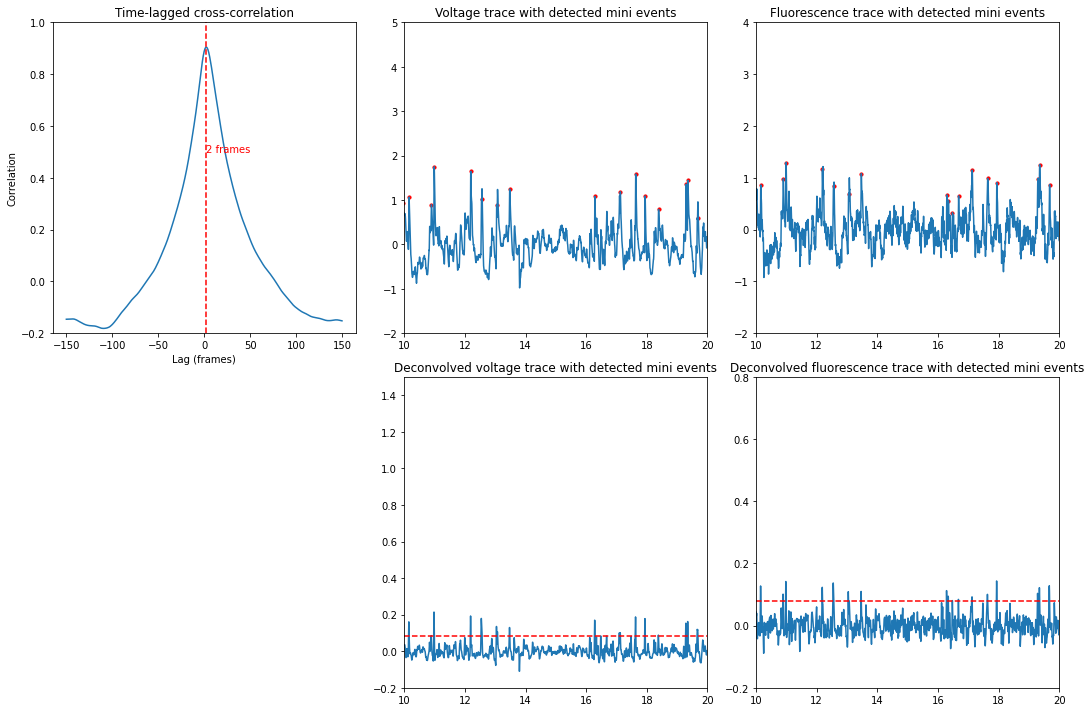

In [25]:
md.save_QC_figure(zoom_range=[10, 20])

In [59]:
# first show the voltage trace with detected mini events
window = [10, 20]
example_trace_path = os.path.join(save_dir, os.path.basename(pkl_file).replace('.pkl', '_vtrace_example.png'))
show_neuron_trace(tf, md.vtrace, md.v_mini_pos, window=window, ylim=[-1,3], 
                  line_color='k', line_width=0.7, thr_or_marker=False, peak_color='r', peak_height=2.8, marker_size=8, save_path=example_trace_path)

In [60]:
# then show the deconvoled voltage trace with threshold
t_decon = tf[:len(md.decon_ftrace)]
example_trace_path = os.path.join(save_dir, os.path.basename(pkl_file).replace('.pkl', '_decon_vtrace_example.png'))
show_neuron_trace(t_decon, md.decon_vtrace, md.v_mini_pos, window=window, ylim=[-0.1,0.3], 
                  line_color='k', line_width=0.7, thr_or_marker=True, peak_color='r', peak_height=2.5, marker_size=2, save_path=example_trace_path)

In [61]:
# Second show the fluorescence trace with detected mini events
example_trace_path = os.path.join(save_dir, os.path.basename(pkl_file).replace('.pkl', '_ftrace_example.png'))
show_neuron_trace(tf, gaussian_filter(md.ftrace, 2), md.f_mini_pos, window=window, ylim=[-1,3], 
                  line_color='#0F9ED5', line_width=0.7, thr_or_marker=False, peak_color='g', peak_height=2.8, marker_size=8, save_path=example_trace_path)

In [62]:
# then show the deconvoled fluorescence trace with threshold
t_decon = tf[:len(md.decon_ftrace)]
example_trace_path = os.path.join(save_dir, os.path.basename(pkl_file).replace('.pkl', '_decon_ftrace_example.png'))
show_neuron_trace(t_decon, md.decon_ftrace, md.f_mini_pos, window=window, ylim=[-0.1,0.3],
                   line_color='#0F9ED5', line_width=0.7, thr_or_marker=True, peak_color='r', peak_height=2.5, marker_size=2, save_path=example_trace_path)

### Voltron2

In [63]:
pkl_files = glob.glob(os.path.join('./dual_recording_dataset/mini_detection_results/', 'Voltron*.pkl'))
pkl_files.sort()
save_dir = './dual_recording_dataset/mini_detection_results/Voltron2'

In [64]:
index = 1
pkl_file = pkl_files[index]
with open(pkl_file, 'rb') as f:
    data = pickle.load(f)  #{'vtrace': test_trace_v, 'tv': tv, 'ftrace': test_trace_f, 'tf': tf, 'template_peaks':selected_peaks, 'template': template, 'decon_template': decontemplate}
test_trace_v = data['vtrace']
tv = data['tv']
test_trace_f = data['ftrace']
tf = data['tf']

md = MiniDetection(test_trace_f, tf, test_trace_v, tv, template_peak_offset=template_peak_offset, vthresh=2.5, fthresh=2.5)
md.filter_traces(low_cutoff, high_cutoff)
md.decon_template = global_template
md.decon_vtrace = md.deconvolve(md.vtrace, md.decon_template, filter_sigma=3, hp_cutoff=2)
md.decon_ftrace = md.deconvolve(md.ftrace, md.decon_template, filter_sigma=3, hp_cutoff=2)  # applying gaussian filter is commutative with the deconvolution
fpr, fnr = md.compare_ephys_optical_detection(wid=4, distance=20)
print('False positive rate:', fpr)
print('False negative rate:', fnr)

False positive rate: 0.48484848484848486
False negative rate: 0.7166666666666667


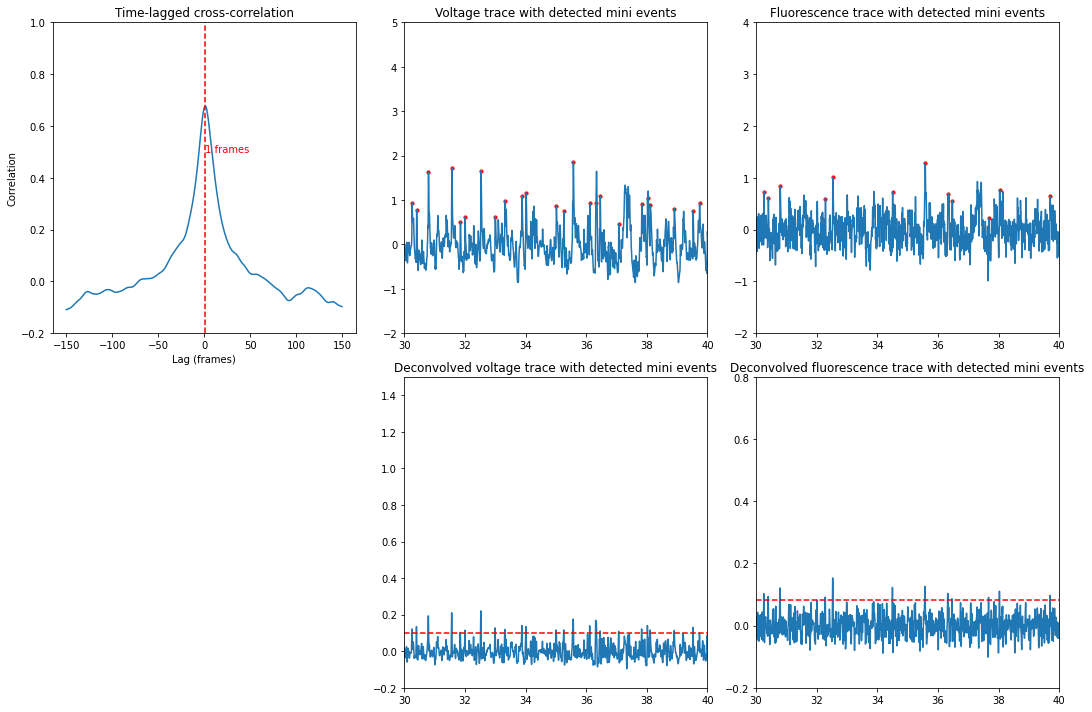

In [65]:
md.save_QC_figure(zoom_range=[30, 40])  # 1, 30, 40

In [66]:
# first show the voltage trace with detected mini events
window = [30, 40]
example_trace_path = os.path.join(save_dir, os.path.basename(pkl_file).replace('.pkl', '_vtrace_example.png'))
show_neuron_trace(tf, md.vtrace, md.v_mini_pos, window=window, ylim=[-1,3], 
                  line_color='k', line_width=0.7, thr_or_marker=False, peak_color='r', peak_height=2.8, marker_size=8, save_path=example_trace_path)

In [67]:
# then show the deconvoled voltage trace with threshold
t_decon = tf[:len(md.decon_ftrace)]
example_trace_path = os.path.join(save_dir, os.path.basename(pkl_file).replace('.pkl', '_decon_vtrace_example.png'))
show_neuron_trace(t_decon, md.decon_vtrace, md.v_mini_pos, window=window, ylim=[-0.1,0.3], 
                  line_color='k', line_width=0.7, thr_or_marker=True, peak_color='r', peak_height=2.5, marker_size=2, save_path=example_trace_path)

In [70]:
# Second show the fluorescence trace with detected mini events
example_trace_path = os.path.join(save_dir, os.path.basename(pkl_file).replace('.pkl', '_ftrace_example.png'))
show_neuron_trace(tf, gaussian_filter(md.ftrace, 2), md.f_mini_pos, window=window, ylim=[-1,3], 
                  line_color='#EF8736', line_width=0.7, thr_or_marker=False, peak_color='g', peak_height=2.8, marker_size=8, save_path=example_trace_path)

In [71]:
# then show the deconvoled fluorescence trace with threshold
t_decon = tf[:len(md.decon_ftrace)]
example_trace_path = os.path.join(save_dir, os.path.basename(pkl_file).replace('.pkl', '_decon_ftrace_example.png'))
show_neuron_trace(t_decon, md.decon_ftrace, md.f_mini_pos, window=window, ylim=[-0.1,0.3],
                   line_color='#EF8736', line_width=0.7, thr_or_marker=True, peak_color='r', peak_height=2.5, marker_size=2, save_path=example_trace_path)

### Collect all the noisy traces and send to Igor

In [17]:
working_dir = './dual_recording_dataset/mini_detection_results/ASAP5_addnoise'
pkl_files = glob.glob(os.path.join(working_dir, '*_detection_results.pkl'))
pkl_files.sort()
pkl_files

['./dual_recording_dataset/mini_detection_results/ASAP5/ASAP5_1_mini_data_detection_results.pkl',
 './dual_recording_dataset/mini_detection_results/ASAP5/ASAP5_2_mini_data_detection_results.pkl',
 './dual_recording_dataset/mini_detection_results/ASAP5/ASAP5_3_mini_data_detection_results.pkl',
 './dual_recording_dataset/mini_detection_results/ASAP5/ASAP5_4_mini_data_detection_results.pkl',
 './dual_recording_dataset/mini_detection_results/ASAP5/ASAP5_5_mini_data_detection_results.pkl',
 './dual_recording_dataset/mini_detection_results/ASAP5/ASAP5_7_mini_data_detection_results.pkl']

In [18]:
v_traces = []
f_traces = []
for pkl_file in pkl_files:
    with open(pkl_file, 'rb') as f:
        data = pickle.load(f)  #keys: ['v_mini_pos', 'f_mini_pos', 'v_to_f_lag', 'lag_corr', 'vtrace', 'ftrace']
        vtrace = data['raw_vtrace']
        ftrace = data['raw_ftrace']
        v_traces.append(vtrace)
        f_traces.append(ftrace)

# save v_traces and f_traces into a pickle file
save_path = os.path.join(working_dir, 'ASAP5_added_noise.pkl')
with open(save_path, 'wb') as f:
    pickle.dump({'v_traces':v_traces, 'f_traces':f_traces}, f)

In [22]:
v_traces[0].shape

(24000,)